In [23]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import display, Image


def process_data(base_dirs=None):
    """
    Find and process all step_results_eval.csv files.

    Returns a dictionary of processed data for each dataset-model-optimizer combination.
    """
    # Try multiple base directories if not specified
    if base_dirs is None:
        base_dirs = ["../results", "results", "./results", "../../results"]

    # Find a valid base directory
    valid_base_dir = None
    for base_dir in base_dirs:
        if os.path.exists(base_dir):
            valid_base_dir = base_dir
            break

    if not valid_base_dir:
        print("No valid base directory found")
        return {}

    print(f"Using base directory: {valid_base_dir}")

    # Find all CSV files using os.walk
    csv_files = []
    for root, dirs, files in os.walk(valid_base_dir):
        for file in files:
            if file == "step_results_eval.csv" and "hyper" not in root:
                csv_files.append(os.path.join(root, file))

    print(f"Found {len(csv_files)} CSV files (excluding 'hyper' paths)")

    # Group files by dataset-model-optimizer
    grouped_files = defaultdict(list)

    for file_path in csv_files:
        # Extract components from path
        parts = file_path.split(os.sep)
        dataset = model = optimizer = seed = None

        # Look for 'results' directory in path
        for i, part in enumerate(parts):
            if part == "results" and i + 3 < len(parts):
                dataset = parts[i + 1]
                model = parts[i + 2]
                optimizer = parts[i + 3]
                break

        # Find seed part
        for part in parts:
            if part.startswith("seed"):
                seed = part
                break

        # Skip if we couldn't identify all components
        if not all([dataset, model, optimizer, seed]):
            continue

        # Group by dataset-model-optimizer
        key = f"{dataset}-{model}-{optimizer}"
        grouped_files[key].append((seed, file_path))

    print(f"Grouped into {len(grouped_files)} dataset-model-optimizer combinations")

    # Process each combination
    processed_data = {}

    for key, files in grouped_files.items():
        print(f"Processing {key}...")

        # Load data from each seed
        seed_dfs = {}
        for seed, file_path in files:
            try:
                df = pd.read_csv(file_path)
                if not df.empty and "step" in df.columns and "test_score" in df.columns:
                    seed_dfs[seed] = df
            except Exception as e:
                pass  # Skip files that can't be read

        # Skip if no valid data was loaded
        if not seed_dfs:
            continue

        # Get all unique steps across seeds
        all_steps = set()
        for df in seed_dfs.values():
            all_steps.update(df["step"].unique())

        sorted_steps = sorted(all_steps)

        # Calculate statistics for each step
        step_stats = []
        for step in sorted_steps:
            scores = []
            for seed, df in seed_dfs.items():
                step_data = df[df["step"] == step]
                if not step_data.empty:
                    scores.append(step_data["test_score"].iloc[0])

            if scores:
                mean = np.mean(scores)
                std = np.std(scores, ddof=1) if len(scores) > 1 else 0
                step_stats.append(
                    {
                        "step": step,
                        "mean": mean,
                        "std": std,
                        "lower": mean - std,
                        "upper": mean + std,
                    }
                )

        # Store processed data
        processed_data[key] = {
            "dataset": key.split("-")[0],
            "model": key.split("-")[1],
            "optimizer": key.split("-")[2],
            "num_seeds": len(seed_dfs),
            "stats": pd.DataFrame(step_stats),
        }

    return processed_data


def create_score_vs_steps_plots(processed_data, output_dir="plots"):
    """
    Create score vs steps plots for all dataset-model-optimizer combinations.
    Returns a dictionary of plot paths.
    """
    os.makedirs(output_dir, exist_ok=True)
    plot_paths = {}

    for key, data in processed_data.items():
        # Extract components
        dataset = data["dataset"]
        model = data["model"]
        optimizer = data["optimizer"]
        stats_df = data["stats"]
        num_seeds = data["num_seeds"]

        # Create figure
        plt.figure(figsize=(10, 6))

        # Plot mean line
        plt.plot(
            stats_df["step"], stats_df["mean"], "o-", color="blue", linewidth=2, label="Mean Score"
        )

        # Plot std dev area
        plt.fill_between(
            stats_df["step"],
            stats_df["lower"],
            stats_df["upper"],
            color="blue",
            alpha=0.2,
            label="±1 Std Dev",
        )

        # Set labels and title
        plt.xlabel("Step")
        plt.ylabel("Test Score")
        plt.title(f"Score vs Steps: {dataset} - {model} - {optimizer}")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()

        # Add the number of seeds used as a text annotation
        plt.figtext(0.01, 0.01, f"Seeds: {num_seeds}", fontsize=8)

        # Save the figure
        plot_path = os.path.join(output_dir, f"{key}.png")
        plt.savefig(plot_path, dpi=300, bbox_inches="tight")
        plt.close()

        plot_paths[key] = plot_path

    print(f"Created {len(plot_paths)} plots in {output_dir}")
    return plot_paths


def display_plot(dataset, model, optimizer, output_dir="plots"):
    """
    Display a specific plot.
    """
    key = f"{dataset}-{model}-{optimizer}"
    plot_path = os.path.join(output_dir, f"{key}.png")

    if os.path.exists(plot_path):
        img = Image(filename=plot_path)
        display(img)
        return True
    else:
        print(f"Plot not found: {plot_path}")
        return False

In [24]:
processed_data = process_data()
plot_paths = create_score_vs_steps_plots(processed_data)


# Show example usage
print("\nExample usage to display plots:")
key = next(iter(plot_paths.keys()))
dataset, model, optimizer = key.split("-")
print(f"display_plot('{dataset}', '{model}', '{optimizer}')")

Using base directory: ../results
Found 2 CSV files (excluding 'hyper' paths)
Grouped into 0 dataset-model-optimizer combinations
Created 0 plots in plots

Example usage to display plots:


StopIteration: 

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image


def create_plots(output_dir="plots"):
    """Find data, process it, and create plots"""
    # Find base directory
    for base_dir in ["../results", "results", "./results"]:
        if os.path.exists(base_dir):
            break
    else:
        print("No results directory found")
        return {}

    # Find and process files
    data = {}
    for root, _, files in os.walk(base_dir):
        if "hyper" in root:
            continue

        if "step_results_eval.csv" in files:
            # Extract path components
            parts = root.split(os.sep)
            results_idx = -1

            for i, part in enumerate(parts):
                if part == "results":
                    results_idx = i
                    break

            if results_idx >= 0 and results_idx + 3 < len(parts):
                dataset = parts[results_idx + 1]
                model = parts[results_idx + 2]
                optimizer = parts[results_idx + 3]

                # Find seed
                seed = None
                for part in parts:
                    if part.startswith("seed"):
                        seed = part
                        break

                if seed:
                    key = f"{dataset}-{model}-{optimizer}"
                    file_path = os.path.join(root, "step_results_eval.csv")

                    try:
                        # Read CSV
                        df = pd.read_csv(file_path)

                        # Check for required columns
                        if "step" in df.columns and "test_score" in df.columns:
                            # Add to data dictionary
                            if key not in data:
                                data[key] = {
                                    "dataset": dataset,
                                    "model": model,
                                    "optimizer": optimizer,
                                    "seeds": {},
                                }

                            data[key]["seeds"][seed] = df
                    except:
                        pass  # Skip problematic files

    # Create plots
    os.makedirs(output_dir, exist_ok=True)
    plot_paths = {}

    for key, item in data.items():
        # Calculate statistics
        all_steps = set()
        for df in item["seeds"].values():
            all_steps.update(df["step"].unique())

        step_stats = []
        for step in sorted(all_steps):
            scores = []
            for df in item["seeds"].values():
                matching = df[df["step"] == step]
                if not matching.empty:
                    scores.append(matching["test_score"].iloc[0])

            if scores:
                mean = np.mean(scores)
                std = np.std(scores, ddof=1) if len(scores) > 1 else 0
                step_stats.append(
                    {
                        "step": step,
                        "mean": mean,
                        "std": std,
                        "lower": mean - std,
                        "upper": mean + std,
                    }
                )

        # Skip if no stats
        if not step_stats:
            continue

        # Convert to DataFrame
        stats_df = pd.DataFrame(step_stats)

        # Create plot
        plt.figure(figsize=(10, 6))
        plt.plot(
            stats_df["step"], stats_df["mean"], "o-", color="blue", linewidth=2, label="Mean Score"
        )
        plt.fill_between(
            stats_df["step"],
            stats_df["lower"],
            stats_df["upper"],
            color="blue",
            alpha=0.2,
            label="±1 Std Dev",
        )

        plt.xlabel("Step")
        plt.ylabel("Test Score")
        plt.title(f'Score vs Steps: {item["dataset"]} - {item["model"]} - {item["optimizer"]}')
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()

        # Add seed count
        plt.figtext(0.01, 0.01, f'Seeds: {len(item["seeds"])}', fontsize=8)

        # Save plot
        plot_path = os.path.join(output_dir, f"{key}.png")
        plt.savefig(plot_path, dpi=300, bbox_inches="tight")
        plt.close()

        plot_paths[key] = plot_path

    print(f"Created {len(plot_paths)} plots in {output_dir}")
    return plot_paths


def show_plot(dataset, model, optimizer, output_dir="plots"):
    """Display a specific plot"""
    key = f"{dataset}-{model}-{optimizer}"
    plot_path = os.path.join(output_dir, f"{key}.png")

    if os.path.exists(plot_path):
        display(Image(filename=plot_path))
        return True
    else:
        print(f"Plot not found: {plot_path}")
        return False


# Run this to create all plots
if __name__ == "__main__":
    plots = create_plots()

    # Example usage
    if plots:
        print("\nTo display a plot, use:")
        key = next(iter(plots))
        dataset, model, optimizer = key.split("-")
        print(f"show_plot('{dataset}', '{model}', '{optimizer}')")

Created 0 plots in plots


Created 0 plots in plots


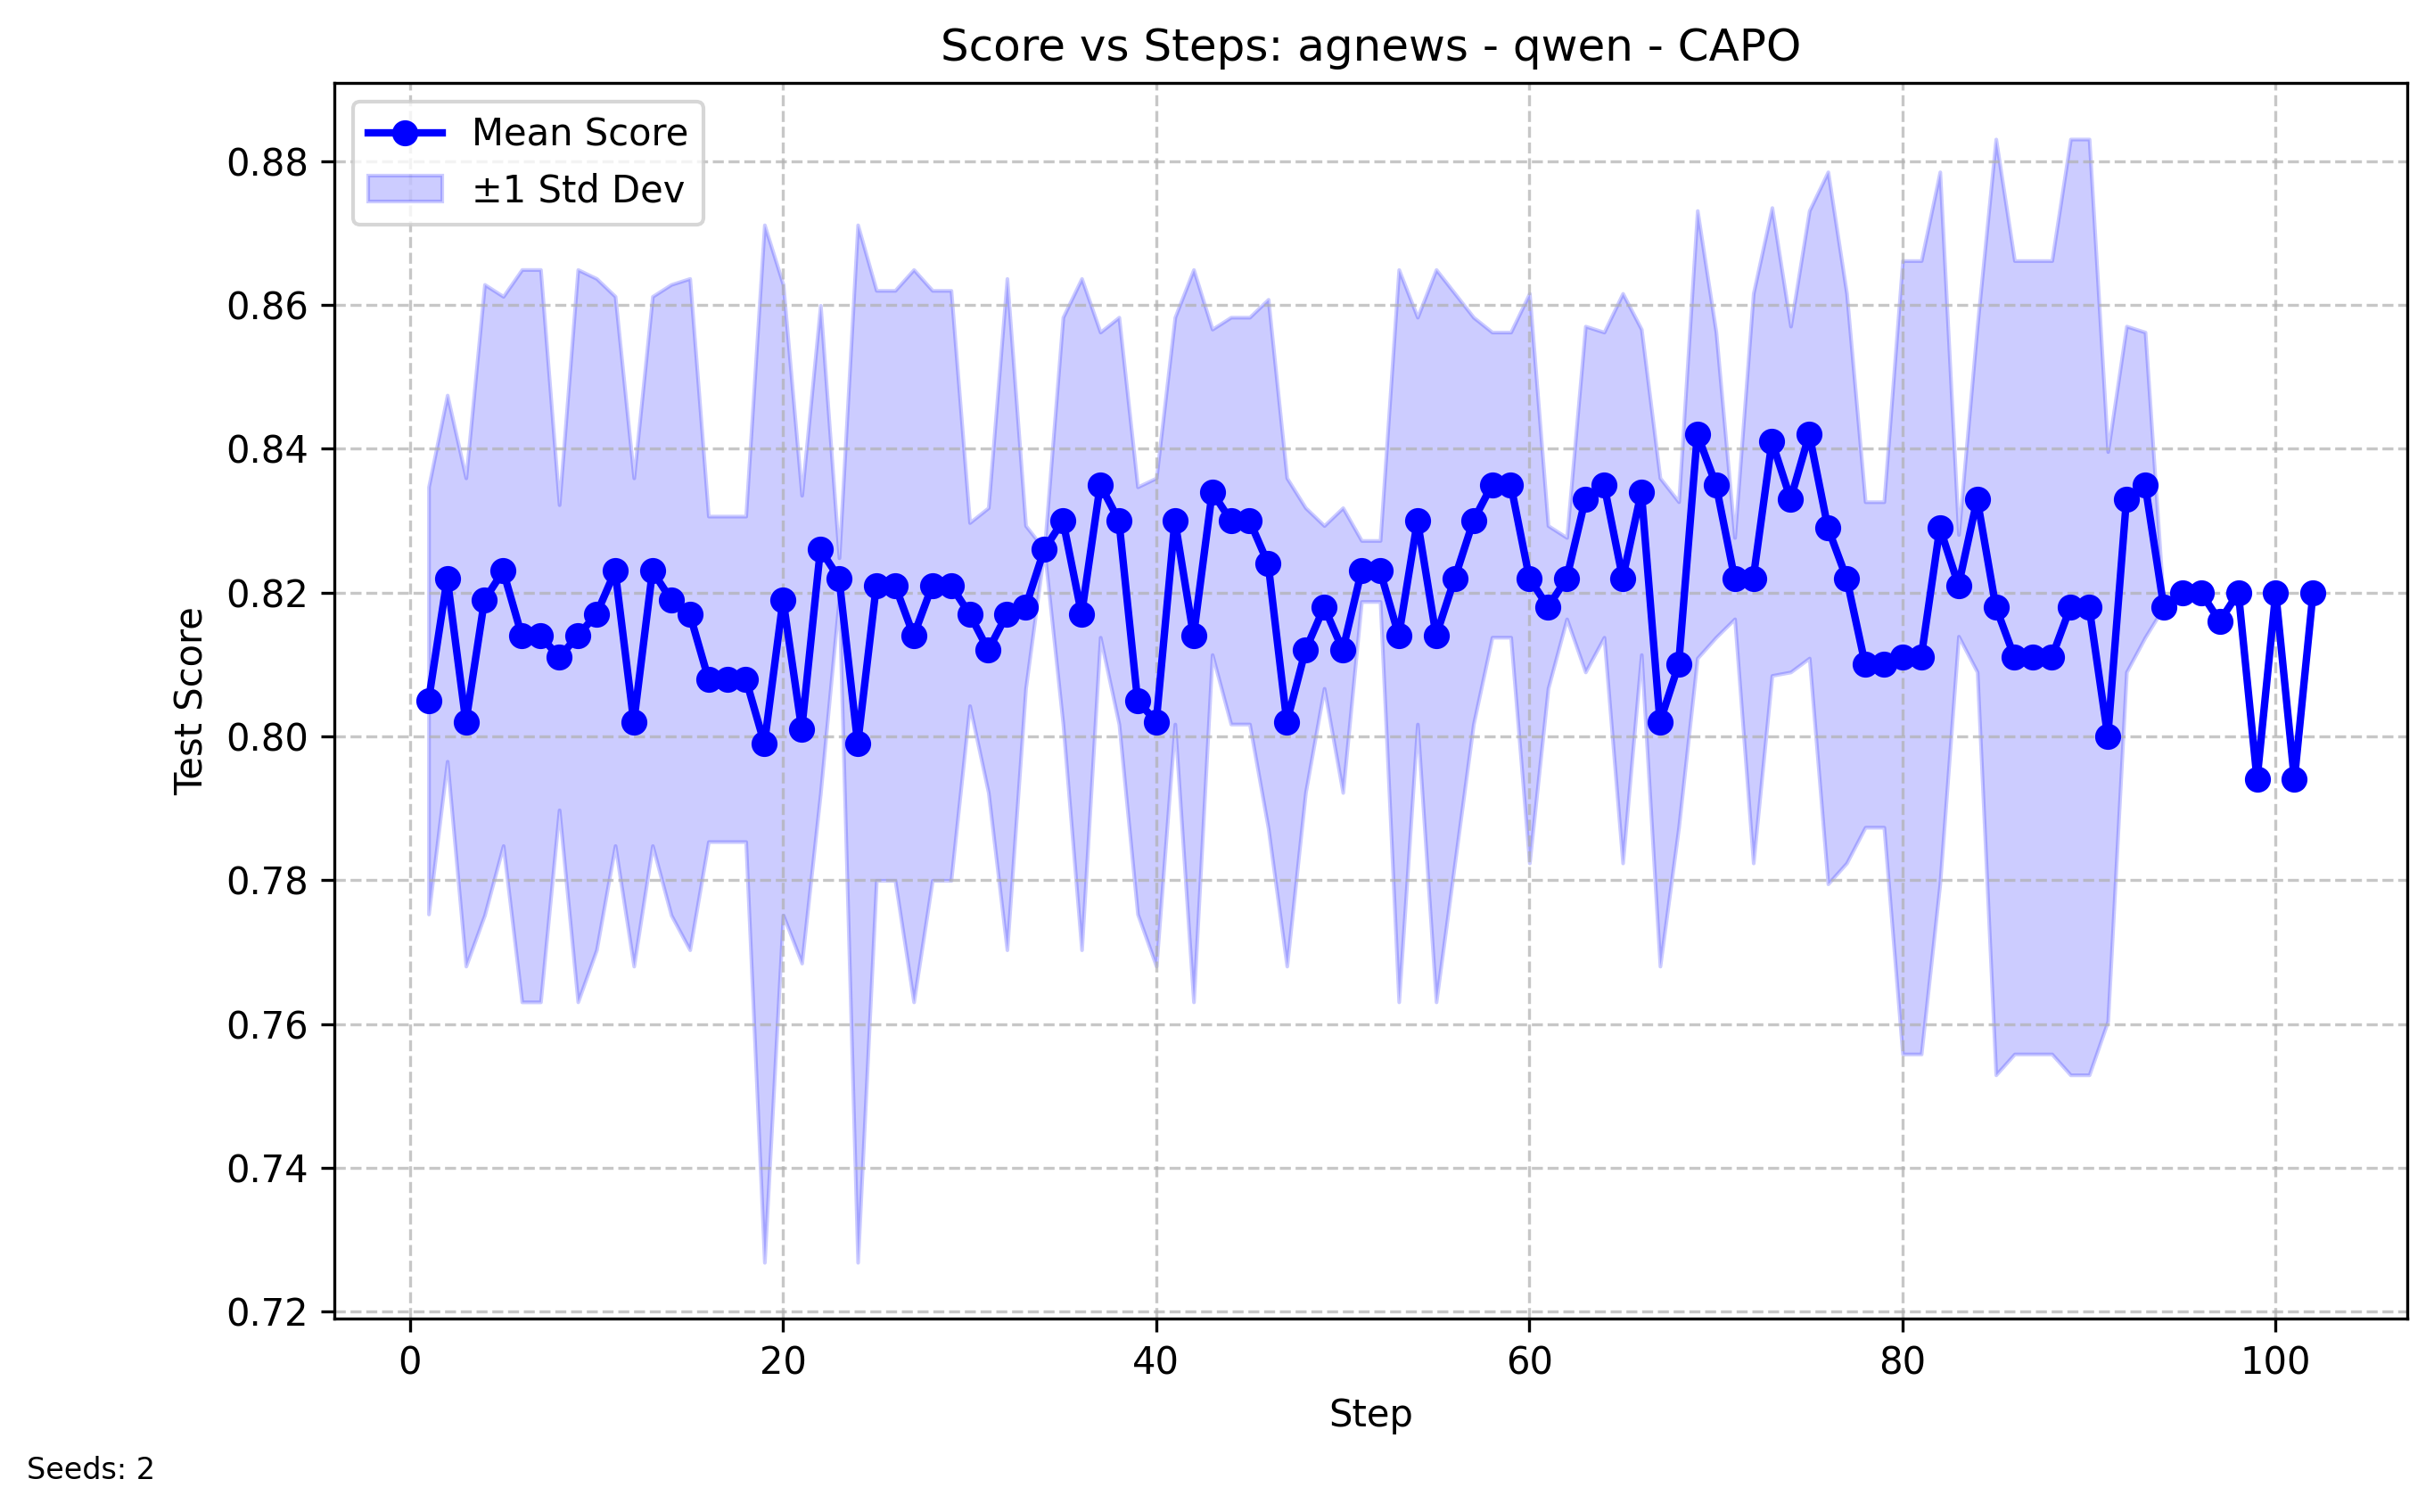

True

In [26]:
# Step 1: Create all plots (run once)
plots = create_plots()

# Step 2: Display a specific plot when needed
show_plot("agnews", "qwen", "CAPO")